# Create Pytorch Geometric Data Objects

In [1]:
import pandas as pd
import osmnx as ox
import networkx as nx
from tqdm import tqdm
import geopandas as gpd
from utils import createPytorchData

## Cargar datos de santiago y mapa de OSM

In [35]:
nodos_santiago = pd.read_csv('Data/dataset_temuco_ismt.csv')
nodos_santiago

,latlong,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,node_id,division,lat_trans,lon_trans,ismtpn
0,"-38.697697,-72.53198748",0.445180,0.289217,-0.149913,-0.445436,-0.039854,-0.002562,-38.697697,-72.531987,6008448745,Temuco,-8.074224e+06,-4.678461e+06,0.633624
1,"-38.698082039999996,-72.53261330666666",0.179484,0.373270,0.058244,-0.541078,-0.189430,-0.224754,-38.698082,-72.532613,6008448745,Temuco,-8.074294e+06,-4.678516e+06,0.633624
2,"-38.69846708,-72.53323913333332",0.452997,0.198302,-0.178206,-0.378966,-0.082231,-0.062554,-38.698467,-72.533239,6148151723,Temuco,-8.074363e+06,-4.678571e+06,0.633624
3,"-38.699237159999996,-72.53511661333333",-0.065550,0.382875,0.221863,-0.569366,-0.299909,-0.400384,-38.699237,-72.535117,8429762828,Temuco,-8.074572e+06,-4.678681e+06,0.633624
4,"-38.6996222,-72.53574243999999",-0.027165,0.338142,0.210087,-0.620908,-0.387973,-0.451052,-38.699622,-72.535742,6008448706,Temuco,-8.074642e+06,-4.678736e+06,0.633624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14447,"-38.77740028,-72.59957676",-0.493202,0.118825,0.352594,-0.253660,-0.417385,-0.406919,-38.777400,-72.599577,1929035945,Padre Las Casas,-8.081748e+06,-4.689836e+06,0.644108
14448,"-38.77740028,-72.60020258666667",-0.198235,0.484669,0.344464,-0.715450,-0.433764,-0.553341,-38.777400,-72.600203,4872709261,Padre Las Casas,-8.081818e+06,-4.689836e+06,0.644108
14449,"-38.77740028,-72.60145424",0.742392,-0.064253,-0.547531,0.128649,0.441367,0.560861,-38.777400,-72.601454,4872709263,Padre Las Casas,-8.081957e+06,-4.689836e+06,0.644108
14450,"-38.77778532,-72.59895093333333",-0.405455,0.097467,0.377425,-0.292914,-0.453532,-0.464444,-38.777785,-72.598951,8684465131,Padre Las Casas,-8.081678e+06,-4.689891e+06,0.644108


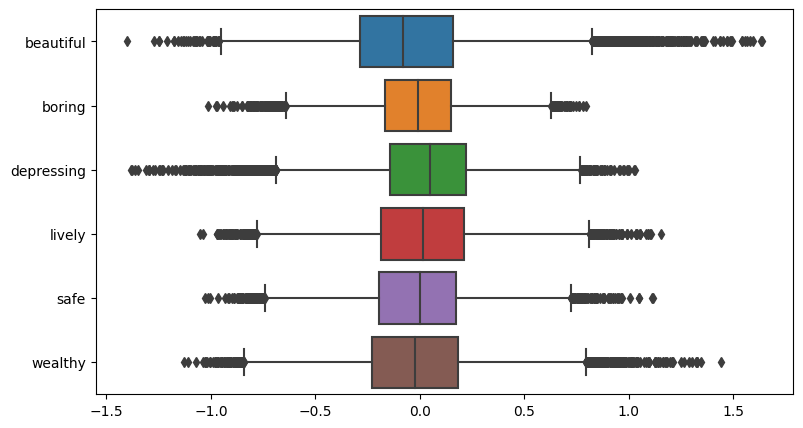

14452

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcula los cuartiles
Q1 = nodos_santiago.iloc[:, [1,2,3,4,5,6]].quantile(0.25)
Q3 = nodos_santiago.iloc[:, [1,2,3,4,5,6]].quantile(0.75)
IQR = Q3 - Q1

# # Define el rango intercuartílico para identificar los outliers
# filtro_outliers = (nodos_santiago.iloc[:, [1,2,3,4,5,6]] < (Q1 - 1.5 * IQR)) | (nodos_santiago.iloc[:, [1,2,3,4,5,6]] > (Q3 + 1.5 * IQR))

# # Aplica el filtro y elimina los outliers
# nodos_santiago = nodos_santiago[~filtro_outliers.any(axis=1)]

# Grafica el boxplot sin outliers
plt.figure(figsize=(9,5))
boxplot_sin_outliers = sns.boxplot(data=nodos_santiago.iloc[:, [1,2,3,4,5,6]], orient="h")
plt.show()
len(nodos_santiago)


### Cambiar nombre comuna a int

In [37]:
nodos_santiago['division_num'] = pd.Categorical(nodos_santiago['division']).codes
print(nodos_santiago[['division', 'division_num']].drop_duplicates()[:5])

              division  division_num
0               Temuco             1
11893  Padre Las Casas             0


In [38]:
num2div = {}
div2num = {}
for _, row in nodos_santiago[['division', 'division_num']].drop_duplicates().iterrows():
    num2div[row.division_num] = row.division
    div2num[row.division] = row.division_num

In [39]:
import pickle
with open('Data/Comunas/temuco_division2numbers.pkl', 'wb') as fp:
    pickle.dump(div2num, fp)
with open('Data/Comunas/temuco_numbers2division.pkl', 'wb') as fp:
    pickle.dump(num2div, fp)

### Cambiar categoría GSE a int

In [14]:
nodos_santiago['ave_gse_num'] = pd.Categorical(nodos_santiago['AVE_GSE']).codes
print(nodos_santiago[['AVE_GSE', 'ave_gse_num']].drop_duplicates()[:5])

      AVE_GSE  ave_gse_num
0        ABC1            0
911        C2            1
1848       C3            2
2250        D            3
13510       E            4


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27444\1096910533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodos_santiago['ave_gse_num'] = pd.Categorical(nodos_santiago['AVE_GSE']).codes


In [15]:
num2gse = {}
gse2num = {}
for _, row in nodos_santiago[['AVE_GSE', 'ave_gse_num']].drop_duplicates().iterrows():
    num2gse[row.ave_gse_num] = row.AVE_GSE
    gse2num[row.AVE_GSE] = row.ave_gse_num

In [7]:
import pickle
with open('Data/ISMT/gse2numbers.pkl', 'wb') as fp:
    pickle.dump(gse2num, fp)
with open('Data/ISMT/numbers2gse.pkl', 'wb') as fp:
    pickle.dump(num2gse, fp)

In [139]:
G = ox.load_graphml("Maps/temuco_drive.graphml")
print(f'Number of nodes: {len(G.nodes())}')
print(f'Number of edges: {len(G.edges())}')
print(f'Number of strongly conncected components: {nx.number_strongly_connected_components(G)}')

Number of nodes: 29022
Number of edges: 56332
Number of strongly conncected components: 860


In [140]:
components_length = [len(list(component)) for component in list(nx.strongly_connected_components(G))]
components_length.sort(reverse=True)
print(f"{round(components_length[0]/len(G.nodes()),5) * 100}% of nodes in one component")

97.04% of nodes in one component


## Add values to the complementary nodes of the OSM Graph

In [141]:
def get_nodes_attrs(G):
    attributes = {}
    for node, attrs in G.nodes.data():
        #print(f"Atributos de {node}: {', '.join(attrs.keys())}")
        for att in attrs.keys():
            if att not in attributes:
                attributes[att] = 0
            attributes[att] += 1
    return attributes

def get_edges_attrs(G):
    edges_atts = {}
    for u, v, attr in G.edges.data():
        for att in attr.keys():
            if att not in edges_atts:
                edges_atts[att] = 0
            edges_atts[att] += 1
    return edges_atts

In [142]:
# Se agregan los atributos como "boring", "lively" etc. a los nodos existentes que se encuentran en el grafo G
# for _, row in nodos_santiago.iterrows():
#     G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
#                depressing=row.depressing, lively=row.lively,
#                safe=row.safe, wealthy=row.wealthy, division=row.division_num, ismt=row.prom_ismt,
#                houses=row.hogares, hog_40pct=row.hog_40pct, pct_hog40p=row.pct_hog40p, ave_gse= row.ave_gse_num, uf=row.uf2018)
    
for _, row in nodos_santiago.iterrows():
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, division=row.division_num, ismt=row.ismtpn, new_lon=row.lon_trans, new_lat=row.lat_trans)

In [143]:
# Eliminar atributos extras de OSM
for node in G.nodes:
    if 'ref' in G.nodes[node]:
        G.nodes[node].pop('ref', None)
    if 'highway' in G.nodes[node]:
        G.nodes[node].pop('highway', None)
    if 'street_count' in G.nodes[node]:
        G.nodes[node].pop('street_count', None)

In [144]:
for u, v, attr in G.edges.data():
    for name in ['osmid', 'oneway', 'lanes', 'name', 'access', 'maxspeed', 'ref', 'bridge', 'junction', 'width', 'tunnel', 'osmid' 'oneway', 'reversed']:
        if name in attr:
            del attr[name]

In [145]:
get_nodes_attrs(G)

{'y': 29022,
 'x': 29022,
 'beautiful': 10196,
 'boring': 10196,
 'depressing': 10196,
 'lively': 10196,
 'safe': 10196,
 'wealthy': 10196,
 'division': 10196,
 'ismt': 10196,
 'new_lon': 10196,
 'new_lat': 10196}

In [112]:
get_edges_attrs(G)

{'highway': 56332, 'length': 56332, 'speed_kph': 56332, 'travel_time': 56332}

In [146]:
df_comunas = gpd.read_file('Data/Comunas/COMUNAS_2020.shp')
df_ismt = gpd.read_file('Data/ISMT_Temuco/ISMT_Temuco.shp')
santiago_division = df_comunas[df_comunas.CUT_REG == '09']

In [147]:
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

In [186]:
df_ismt

,FID,zona,REGION_,NOM_REG,PROVINC,NOM_PRO,COMUNA_,NOM_COM,URBANO,DISTRIT,...,hacin_n,alleg,escolar,mat_cpt,mat_rcp,mat_rrc,ind_mat,Shape__Are,Shape__Len,geometry
0,1,9101011001,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,545,85,12.970890,485,97,2,8.806507,1.039618e+06,6664.907891,"POLYGON ((-8081433.100 -4683110.882, -8081430...."
1,2,9101011002,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,1417,194,14.854181,1382,65,0,8.954388,9.677756e+05,4449.304735,"POLYGON ((-8080980.952 -4683920.402, -8081011...."
2,3,9101011003,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,712,44,14.117647,719,26,3,8.950535,1.093250e+06,4681.650538,"POLYGON ((-8080292.442 -4684930.721, -8080331...."
3,4,9101011004,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,218,74,13.473913,221,9,0,8.956522,3.988803e+05,2870.658145,"POLYGON ((-8080224.067 -4684836.027, -8080224...."
4,5,9101011005,9,REGIÓN DE LA ARAUCANÍA,91,CAUTÍN,9101,TEMUCO,TEMUCO,1,...,992,88,14.224687,968,69,0,8.932498,4.249278e+05,2773.947173,"POLYGON ((-8081155.207 -4684796.124, -8081183...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,224,9211051001,9,REGIÓN DE LA ARAUCANÍA,92,MALLECO,9211,VICTORIA,VICTORIA,5,...,810,24,8.777657,579,319,24,8.557484,1.055271e+06,4774.569162,"POLYGON ((-8051469.986 -4613708.850, -8051468...."
224,225,9211051002,9,REGIÓN DE LA ARAUCANÍA,92,MALLECO,9211,VICTORIA,VICTORIA,5,...,618,12,10.378462,544,101,5,8.824615,6.367056e+05,3647.178836,"POLYGON ((-8051019.451 -4613627.689, -8051022...."
225,226,9211051003,9,REGIÓN DE LA ARAUCANÍA,92,MALLECO,9211,VICTORIA,VICTORIA,5,...,1150,12,9.605769,829,381,38,8.592949,1.292786e+06,5794.825578,"POLYGON ((-8050823.084 -4612151.053, -8050823...."
226,227,9211051004,9,REGIÓN DE LA ARAUCANÍA,92,MALLECO,9211,VICTORIA,VICTORIA,5,...,830,2,9.521739,683,233,4,8.706522,7.723731e+05,3661.299226,"POLYGON ((-8050681.201 -4614538.817, -8050681...."


In [206]:
def getDivision(point):
    for div in santiago_division.geometry:
        if point.within(div):
            return div
        
def getIsmtData(point):
    for com in df_ismt.geometry:
        if point.within(com):
            return com

def setDivisionNum(division: str):
    return div2num[division]

def setGSENum(gse):
    if gse in ['ABC1', 'C2', 'C3', 'D', 'E']:
        return gse2num[gse]
    return

def geoDataProcess(df_extra):
    # Obtener latitud y longitug
    lats = []
    lons = []
    for _, row in df_extra.iterrows():
        node = row.node_id
        new_lat, new_lon = transformer.transform(G.nodes[node]['y'], G.nodes[node]['x'])
        lats.append(G.nodes[node]['y'])
        lons.append(G.nodes[node]['x'])
    df_extra['lat'] = lats
    df_extra['lon'] = lons

    coords_point = gpd.GeoDataFrame(df_extra, geometry=gpd.points_from_xy(df_extra.lon,df_extra.lat))
    coords_point['division'] = coords_point.geometry.apply(getDivision)
    tqdm.pandas()
    coords_point['geo_ismt'] = coords_point.geometry.progress_apply(getIsmtData)
    df_merge = coords_point.merge(santiago_division[['geometry', 'COMUNA']], left_on='division', right_on='geometry')
    df_merge = df_merge.drop(['geometry_x', 'geometry_y', 'division'], axis=1)
    df_merge = df_merge.rename({'COMUNA':'division'}, axis=1)
    df_merge['division_num'] = df_merge.division.apply(setDivisionNum)
    
    df_merge = df_merge.merge(df_ismt[['geometry', 'ismtpn']], left_on='geo_ismt', right_on='geometry', how='left')
    #df_extra = df_merge.drop(['geometry', 'geo_ismt'], axis=1)
    #df_extra = df_extra.rename({'AVE_GSE':'ave_gse'}, axis=1)
    #df_extra['ave_gse_num'] = df_extra.ave_gse.apply(setGSENum)

    return df_merge

In [196]:
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))
len(extra_nodes) + 84252

103078

## Zero Map

In [234]:
# Setear valores de nodos extras en 0
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))
print(f"Number of nodes: {len(extra_nodes)}")
beautiful_values = [0] * len(extra_nodes)
boring_values = [0] * len(extra_nodes)
depressing_values = [0] * len(extra_nodes)
lively_values = [0] * len(extra_nodes)
safe_values = [0] * len(extra_nodes)
wealthy_values = [0] * len(extra_nodes)

columns_name = ['node_id', 'beautiful', 'boring', 'depressing', 'lively', 'safe', 'wealthy']
df_extra = pd.DataFrame(list(zip(extra_nodes, beautiful_values, boring_values, depressing_values,
                                 lively_values, safe_values, wealthy_values)), columns=columns_name)


#df_extra = geoDataProcess(df_extra)

Number of nodes: 18826


In [235]:
df_extra

,node_id,beautiful,boring,depressing,lively,safe,wealthy
0,1175027727,0,0,0,0,0,0
1,2584182799,0,0,0,0,0,0
2,8508009469,0,0,0,0,0,0
3,1408958483,0,0,0,0,0,0
4,1175027733,0,0,0,0,0,0
...,...,...,...,...,...,...,...
18821,8864432122,0,0,0,0,0,0
18822,8864432123,0,0,0,0,0,0
18823,8864432124,0,0,0,0,0,0
18824,8864432125,0,0,0,0,0,0


In [236]:
lats = []
lons = []
lats_trans = []
lons_trans = []
for _, row in df_extra.iterrows():
    node = row.node_id
    new_lat, new_lon = transformer.transform(G.nodes[node]['y'], G.nodes[node]['x'])
    lats.append(G.nodes[node]['y'])
    lons.append(G.nodes[node]['x'])
    lats_trans.append(new_lat)
    lons_trans.append(new_lon)
df_extra['lat'] = lats
df_extra['lon'] = lons
df_extra['new_lat'] = lats_trans
df_extra['new_lon'] = lons_trans

coords_point = gpd.GeoDataFrame(df_extra, geometry=gpd.points_from_xy(df_extra.lon,df_extra.lat))
coords_point['division'] = coords_point.geometry.apply(getDivision)

In [237]:
coords_point = gpd.GeoDataFrame(coords_point, geometry=gpd.points_from_xy(df_extra.new_lat,df_extra.new_lon))
coords_point

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geometry,division
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,POINT (-8077105.442 -4679821.297),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
1,2584182799,0,0,0,0,0,0,-38.745580,-72.554087,-8.076684e+06,-4.685293e+06,POINT (-8076684.020 -4685293.294),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7..."
2,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,POINT (-8084549.566 -4680822.941),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
3,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,POINT (-8079042.457 -4682505.624),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
4,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,POINT (-8080011.048 -4681329.679),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,8864432122,0,0,0,0,0,0,-38.747291,-72.591062,-8.080800e+06,-4.685538e+06,POINT (-8080800.080 -4685537.522),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
18822,8864432123,0,0,0,0,0,0,-38.747478,-72.590924,-8.080785e+06,-4.685564e+06,POINT (-8080784.651 -4685564.170),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
18823,8864432124,0,0,0,0,0,0,-38.746832,-72.591328,-8.080830e+06,-4.685472e+06,POINT (-8080829.658 -4685472.022),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."
18824,8864432125,0,0,0,0,0,0,-38.747061,-72.591186,-8.080814e+06,-4.685505e+06,POINT (-8080813.817 -4685504.693),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5..."


In [238]:
coords_point['geo_ismt'] = coords_point.geometry.progress_apply(getIsmtData)

100%|██████████| 18826/18826 [00:21<00:00, 891.29it/s] 


In [239]:
coords_point

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geometry,division,geo_ismt
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,POINT (-8077105.442 -4679821.297),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8076125.902 -4678142.206, -8076121...."
1,2584182799,0,0,0,0,0,0,-38.745580,-72.554087,-8.076684e+06,-4.685293e+06,POINT (-8076684.020 -4685293.294),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",None
2,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,POINT (-8084549.566 -4680822.941),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8084553.294 -4680271.022, -8084544...."
3,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,POINT (-8079042.457 -4682505.624),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8079148.695 -4682592.944, -8079167...."
4,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,POINT (-8080011.048 -4681329.679),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,8864432122,0,0,0,0,0,0,-38.747291,-72.591062,-8.080800e+06,-4.685538e+06,POINT (-8080800.080 -4685537.522),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8080353.177 -4685239.061, -8080358...."
18822,8864432123,0,0,0,0,0,0,-38.747478,-72.590924,-8.080785e+06,-4.685564e+06,POINT (-8080784.651 -4685564.170),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8080353.177 -4685239.061, -8080358...."
18823,8864432124,0,0,0,0,0,0,-38.746832,-72.591328,-8.080830e+06,-4.685472e+06,POINT (-8080829.658 -4685472.022),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8080353.177 -4685239.061, -8080358...."
18824,8864432125,0,0,0,0,0,0,-38.747061,-72.591186,-8.080814e+06,-4.685505e+06,POINT (-8080813.817 -4685504.693),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8080353.177 -4685239.061, -8080358...."


In [240]:
df_merge = coords_point.merge(santiago_division[['geometry', 'COMUNA']], left_on='division', right_on='geometry')


In [241]:
df_merge

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geometry_x,division,geo_ismt,geometry_y,COMUNA
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,POINT (-8077105.442 -4679821.297),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8076125.902 -4678142.206, -8076121....","POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",Temuco
1,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,POINT (-8084549.566 -4680822.941),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8084553.294 -4680271.022, -8084544....","POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",Temuco
2,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,POINT (-8079042.457 -4682505.624),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8079148.695 -4682592.944, -8079167....","POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",Temuco
3,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,POINT (-8080011.048 -4681329.679),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",None,"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",Temuco
4,9550790681,0,0,0,0,0,0,-38.714587,-72.634257,-8.085608e+06,-4.680871e+06,POINT (-8085608.448 -4680870.678),"POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...","POLYGON ((-8085093.639 -4681044.768, -8085119....","POLYGON ((-72.63945 -38.55166, -72.63908 -38.5...",Temuco
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,2584182643,0,0,0,0,0,0,-38.745002,-72.555689,-8.076862e+06,-4.685211e+06,POINT (-8076862.409 -4685210.811),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",None,"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",Padre Las Casas
18822,2584182673,0,0,0,0,0,0,-38.745069,-72.563926,-8.077779e+06,-4.685220e+06,POINT (-8077779.337 -4685220.402),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",None,"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",Padre Las Casas
18823,280788943,0,0,0,0,0,0,-38.767878,-72.581874,-8.079777e+06,-4.688476e+06,POINT (-8079777.266 -4688476.433),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",None,"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",Padre Las Casas
18824,9160392685,0,0,0,0,0,0,-38.767721,-72.608834,-8.082778e+06,-4.688454e+06,POINT (-8082778.450 -4688454.046),"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",None,"POLYGON ((-72.43050 -38.72202, -72.43040 -38.7...",Padre Las Casas


In [242]:
df_merge = df_merge.drop(['geometry_x', 'geometry_y', 'division'], axis=1)
df_merge

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geo_ismt,COMUNA
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,"POLYGON ((-8076125.902 -4678142.206, -8076121....",Temuco
1,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,"POLYGON ((-8084553.294 -4680271.022, -8084544....",Temuco
2,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,"POLYGON ((-8079148.695 -4682592.944, -8079167....",Temuco
3,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,None,Temuco
4,9550790681,0,0,0,0,0,0,-38.714587,-72.634257,-8.085608e+06,-4.680871e+06,"POLYGON ((-8085093.639 -4681044.768, -8085119....",Temuco
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,2584182643,0,0,0,0,0,0,-38.745002,-72.555689,-8.076862e+06,-4.685211e+06,None,Padre Las Casas
18822,2584182673,0,0,0,0,0,0,-38.745069,-72.563926,-8.077779e+06,-4.685220e+06,None,Padre Las Casas
18823,280788943,0,0,0,0,0,0,-38.767878,-72.581874,-8.079777e+06,-4.688476e+06,None,Padre Las Casas
18824,9160392685,0,0,0,0,0,0,-38.767721,-72.608834,-8.082778e+06,-4.688454e+06,None,Padre Las Casas


In [243]:
df_merge = df_merge.rename({'COMUNA':'division'}, axis=1)

In [244]:
df_merge['division_num'] = df_merge.division.apply(setDivisionNum)

In [245]:
df_merge

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geo_ismt,division,division_num
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,"POLYGON ((-8076125.902 -4678142.206, -8076121....",Temuco,1
1,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,"POLYGON ((-8084553.294 -4680271.022, -8084544....",Temuco,1
2,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,"POLYGON ((-8079148.695 -4682592.944, -8079167....",Temuco,1
3,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,None,Temuco,1
4,9550790681,0,0,0,0,0,0,-38.714587,-72.634257,-8.085608e+06,-4.680871e+06,"POLYGON ((-8085093.639 -4681044.768, -8085119....",Temuco,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,2584182643,0,0,0,0,0,0,-38.745002,-72.555689,-8.076862e+06,-4.685211e+06,None,Padre Las Casas,0
18822,2584182673,0,0,0,0,0,0,-38.745069,-72.563926,-8.077779e+06,-4.685220e+06,None,Padre Las Casas,0
18823,280788943,0,0,0,0,0,0,-38.767878,-72.581874,-8.079777e+06,-4.688476e+06,None,Padre Las Casas,0
18824,9160392685,0,0,0,0,0,0,-38.767721,-72.608834,-8.082778e+06,-4.688454e+06,None,Padre Las Casas,0


In [246]:
df_new = df_merge.merge(df_ismt[['geometry', 'ismtpn']], left_on='geo_ismt', right_on='geometry', how='left')
df_new

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,new_lat,new_lon,geo_ismt,division,division_num,geometry,ismtpn
0,1175027727,0,0,0,0,0,0,-38.707231,-72.557873,-8.077105e+06,-4.679821e+06,"POLYGON ((-8076125.902 -4678142.206, -8076121....",Temuco,1,"POLYGON ((-8076125.902 -4678142.206, -8076121....",0.661097
1,8508009469,0,0,0,0,0,0,-38.714252,-72.624744,-8.084550e+06,-4.680823e+06,"POLYGON ((-8084553.294 -4680271.022, -8084544....",Temuco,1,"POLYGON ((-8084553.294 -4680271.022, -8084544....",0.498286
2,1408958483,0,0,0,0,0,0,-38.726046,-72.575273,-8.079042e+06,-4.682506e+06,"POLYGON ((-8079148.695 -4682592.944, -8079167....",Temuco,1,"POLYGON ((-8079148.695 -4682592.944, -8079167....",0.584243
3,1175027733,0,0,0,0,0,0,-38.717804,-72.583974,-8.080011e+06,-4.681330e+06,None,Temuco,1,None,NaN
4,9550790681,0,0,0,0,0,0,-38.714587,-72.634257,-8.085608e+06,-4.680871e+06,"POLYGON ((-8085093.639 -4681044.768, -8085119....",Temuco,1,"POLYGON ((-8085093.639 -4681044.768, -8085119....",0.528153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18821,2584182643,0,0,0,0,0,0,-38.745002,-72.555689,-8.076862e+06,-4.685211e+06,None,Padre Las Casas,0,None,NaN
18822,2584182673,0,0,0,0,0,0,-38.745069,-72.563926,-8.077779e+06,-4.685220e+06,None,Padre Las Casas,0,None,NaN
18823,280788943,0,0,0,0,0,0,-38.767878,-72.581874,-8.079777e+06,-4.688476e+06,None,Padre Las Casas,0,None,NaN
18824,9160392685,0,0,0,0,0,0,-38.767721,-72.608834,-8.082778e+06,-4.688454e+06,None,Padre Las Casas,0,None,NaN


In [252]:
df_new[['node_id', 'lat', 'lon', 'ismtpn']]

,node_id,lat,lon,ismtpn
0,1175027727,-38.707231,-72.557873,0.661097
1,8508009469,-38.714252,-72.624744,0.498286
2,1408958483,-38.726046,-72.575273,0.584243
3,1175027733,-38.717804,-72.583974,NaN
4,9550790681,-38.714587,-72.634257,0.528153
...,...,...,...,...
18821,2584182643,-38.745002,-72.555689,NaN
18822,2584182673,-38.745069,-72.563926,NaN
18823,280788943,-38.767878,-72.581874,NaN
18824,9160392685,-38.767721,-72.608834,NaN


In [255]:
closest_node_idx

14164

In [285]:
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np

X = df_new[['lat', 'lon']].values
nbrs = NearestNeighbors(n_neighbors=40, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

# Iterar sobre las filas y asignar valores a 'ismtpn' NaN
for i, row in tqdm(df_new.iterrows()):
    if pd.isnull(row['ismtpn']):
        nearest_node_with_ismtpn = None
        for idx in indices[i]:
            if not pd.isnull(df_new.at[idx, 'ismtpn']):
                nearest_node_with_ismtpn = idx
                break
        if nearest_node_with_ismtpn is not None:
            df_new.at[i, 'ismtpn'] = df_new.at[nearest_node_with_ismtpn, 'ismtpn']


len(df_new[df_new.ismtpn.isna()])

18826it [00:00, 32770.75it/s]


0

In [287]:
df_new.to_csv('Data/temuco_ismtpn_knn.csv', index=False)

In [33]:
df_extra['ave_gse_num'] = df_extra.ave_gse_num.fillna(-1)
df_extra = df_extra.fillna(0)


In [34]:
df_extra

,node_id,beautiful,boring,depressing,lively,safe,wealthy,lat,lon,division,division_num,prom_ismt,hogares,hog_40pct,pct_hog40p,ave_gse,uf2018,ave_gse_num
0,9565110273,0,0,0,0,0,0,-33.600032,-70.591930,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
1,9565110274,0,0,0,0,0,0,-33.599970,-70.591940,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
2,2393618954,0,0,0,0,0,0,-33.580565,-70.605937,Puente Alto,29,0.778635,1336.0,683.0,0.511228,D,19.307412,3.0
3,9565110275,0,0,0,0,0,0,-33.600001,-70.591939,Puente Alto,29,0.851613,1305.0,206.0,0.157854,C2,19.194239,1.0
4,9538837257,0,0,0,0,0,0,-33.621177,-70.586392,Puente Alto,29,0.749758,1133.0,741.0,0.654016,D,13.774557,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273367,602912427,0,0,0,0,0,0,-33.327393,-70.624826,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273368,602912428,0,0,0,0,0,0,-33.327083,-70.624610,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273369,602914409,0,0,0,0,0,0,-33.330418,-70.627947,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0
273370,602914410,0,0,0,0,0,0,-33.329770,-70.627731,Colina,4,0.000000,0.0,0.0,0.000000,0,0.000000,-1.0


In [288]:
for _, row in tqdm(df_new.iterrows()):
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, division=row.division_num, ismt=row.ismtpn)

18826it [00:01, 10819.51it/s]


In [289]:
nodes_gse = {}
nodes_without_label = []
for node, att in G.nodes(data=True):
    gse = att['ave_gse']
    if gse not in nodes_gse:
        nodes_gse[gse] = 0
    nodes_gse[gse] += 1
    if gse == -1.0:
        nodes_without_label.append(node)
nodes_gse

KeyError: 'ave_gse'

In [37]:
print(f'Nodes to remove: {len(nodes_without_label)}')
G.remove_nodes_from(nodes_without_label)

Nodes to remove: 18563


In [290]:
nodes_ls = list(G.nodes())
c=0
dic_nodes = {}
for node in nodes_ls:
    dic_nodes[node] = c
    c+=1

G = nx.relabel_nodes(G, dic_nodes)

In [291]:
get_nodes_attrs(G)

{'y': 29022,
 'x': 29022,
 'beautiful': 29022,
 'boring': 29022,
 'depressing': 29022,
 'lively': 29022,
 'safe': 29022,
 'wealthy': 29022,
 'division': 29022,
 'ismt': 29022,
 'new_lon': 10196,
 'new_lat': 10196}

In [292]:
#ox.save_graphml(G, "Maps/temuco_drive_attrs.graphml")

In [2]:
G = ox.load_graphml("Maps/temuco_drive_attrs.graphml")

In [3]:
get_nodes_attrs(G)

NameError: name 'get_nodes_attrs' is not defined

In [41]:
%%time
#betweenness_centrality = nx.betweenness_centrality(G, k=5000, weight='length')

CPU times: total: 6h 48min 24s
Wall time: 7h 59min 42s


In [6]:
import pickle
# with open('Data/bc.pkl', 'wb') as fp:
#     pickle.dump(betweenness_centrality, fp)

with open('Data/bc.pkl', 'rb') as fp:
    betweenness_centrality = pickle.load(fp)

In [42]:
eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='length', max_iter=100)
pg_rank= nx.pagerank(G, weight='length')

In [8]:
len(betweenness_centrality), len(eigen_centrality), len(pg_rank)

(337374, 337374, 337374)

In [43]:
for node in tqdm(list(G.nodes())):
    G.nodes[node]['bc'] = 0
    G.nodes[node]['eigen'] = eigen_centrality[node]
    G.nodes[node]['pg_rank'] = pg_rank[node]

  0%|          | 0/337373 [00:00<?, ?it/s]

100%|██████████| 337373/337373 [00:00<00:00, 833468.76it/s]


In [296]:
edges = []
edge_attributes = []
c = 0
for source, target, edge_attrs in G.edges(data=True):
    if c == 10:
        break
    print(edge_attrs)
    c += 1
    #edges.append([source, target])
    #edge_attributes.append([float(edge_attrs['length']), float(edge_attrs['travel_time']), float(edge_attrs['highway']), float(edge_attrs['speed_kph'])])

{'highway': 'motorway', 'length': 33.922, 'speed_kph': 120.0, 'travel_time': 1.0}
{'highway': 'motorway_link', 'length': 11.623, 'speed_kph': 30.0, 'travel_time': 1.4}
{'highway': 'tertiary', 'length': 87.42, 'speed_kph': 50.0, 'travel_time': 6.3}
{'highway': 'tertiary', 'length': 14.738, 'speed_kph': 50.0, 'travel_time': 1.1}
{'highway': 'tertiary', 'length': 7.683, 'speed_kph': 50.0, 'travel_time': 0.6}
{'highway': 'tertiary', 'length': 152.651, 'speed_kph': 50.0, 'travel_time': 11.0}
{'highway': 'secondary', 'length': 33.784, 'speed_kph': 50.5, 'travel_time': 2.4}
{'highway': 'secondary', 'length': 32.555, 'speed_kph': 50.5, 'travel_time': 2.3}
{'highway': 'unclassified', 'length': 15.917, 'speed_kph': 50.0, 'travel_time': 1.1}
{'highway': 'unclassified', 'length': 14.745, 'speed_kph': 50.0, 'travel_time': 1.1}


In [5]:
from utils import createPytorchDataTemuco
createPytorchDataTemuco(G, file_name='temuco_full_graph_2024')

Number of nodes: 29022
Number of edges: 56332
Number of edge attributes: 56332
Size of x tensor: torch.Size([29022, 10])
Size of edge_index tensor: torch.Size([2, 56332])
Size of edge_attributes tensor: torch.Size([56332, 3])
Graph saved as PyTorch in Data/temuco_full_graph_2024.pt


In [3]:
#G = ox.load_graphml("Maps/santiago_drive_zero.graphml")

## Filter Divisions

In [46]:
import pickle
with open('Data/Comunas/division2numbers.pkl', 'rb') as fp:
    div2num = pickle.load(fp)

In [47]:
numbers_commune_filter = []
tests_commune_filter = []
divisions = ['Santiago', 'Providencia', 'Ñuñoa', 'San Joaquín', 'San Miguel', 'Pedro Aguirre Cerda', 'Estación Central', 'Quinta Normal', 'Independencia', 'Recoleta']
test_divisions = ['Vitacura', 'Las Condes', 'Lo Barnechea', 'La Reina', 'Peñalolén']

for elem in divisions:
    numbers_commune_filter.append(div2num[elem])

# for elem in divisions:
#     tests_commune_filter.append(div2num[elem])

print(numbers_commune_filter)
# print(tests_commune_filter)

[39, 27, 42, 35, 37, 23, 7, 31, 9, 32]


In [48]:
for k, v in div2num.items():
    if k not in divisions:
        tests_commune_filter.append(v)

print(tests_commune_filter)

[17, 41, 4, 30, 15, 8, 5, 33, 28, 16, 3, 19, 21, 14, 25, 20, 2, 18, 34, 6, 22, 11, 12, 29, 13, 10, 38, 1, 36, 24, 26, 40, 0]


In [49]:
nodes_to_remove = []
for node, attrs in G.nodes(data=True):
    if int(attrs['division']) not in tests_commune_filter:
        nodes_to_remove.append(node)

print(f"Nodes reduced from {len(list(G.nodes()))} to {len(list(G.nodes())) - len(nodes_to_remove)}")
G.remove_nodes_from(nodes_to_remove)
len(list(G.nodes()))

Nodes reduced from 337373 to 280607


280607

In [50]:
get_nodes_attrs(G)

{'y': 280607,
 'x': 280607,
 'beautiful': 280607,
 'boring': 280607,
 'depressing': 280607,
 'lively': 280607,
 'safe': 280607,
 'wealthy': 280607,
 'division': 280607,
 'ismt': 280607,
 'houses': 280607,
 'hog_40pct': 280607,
 'pct_hog40p': 280607,
 'ave_gse': 280607,
 'uf': 280607,
 'bc': 280607,
 'eigen': 280607,
 'pg_rank': 280607}

In [15]:
get_edges_attrs(G)

{'highway': 543903,
 'length': 543903,
 'speed_kph': 543903,
 'travel_time': 543903}

In [51]:
nodes_ls = list(G.nodes())
c=0
dic_nodes = {}
for node in nodes_ls:
    dic_nodes[node] = c
    c+=1

G = nx.relabel_nodes(G, dic_nodes)

In [52]:
ox.save_graphml(G, "Maps/santiago_downtown_2024.graphml")

In [20]:
G = ox.load_graphml("Maps/santiago_downtown.graphml")

In [21]:
%%time
betweenness_centrality = nx.betweenness_centrality(G, k=5000, weight='length')

CPU times: total: 24min
Wall time: 51min 34s


In [18]:
eigen_centrality = nx.eigenvector_centrality_numpy(G, weight='length', max_iter=100)
pg_rank= nx.pagerank(G, weight='length')

In [18]:
for node in tqdm(list(G.nodes())):
    G.nodes[node]['bc'] = betweenness_centrality[node]
    G.nodes[node]['eigen'] = eigen_centrality[node]
    G.nodes[node]['pg_rank'] = pg_rank[node]

100%|██████████| 280608/280608 [00:00<00:00, 838458.61it/s]


In [53]:
createPytorchData(G, file_name='santiago_downtown_2024')

Number of nodes: 280607
Number of edges: 543901
Number of edge attributes: 543901
Size of x tensor: torch.Size([280607, 18])
Size of edge_index tensor: torch.Size([2, 543901])
Size of edge_attributes tensor: torch.Size([543901, 4])
Graph saved as PyTorch in Data/santiago_downtown_2024.pt


## Mean Global

In [35]:
# Setear valores de nodos extras en media global
ls_nodos_santiago = list(nodos_santiago.node_id.unique())
extra_nodes = list(set(G.nodes()) - set(ls_nodos_santiago))

beautiful_values = [nodos_santiago['beautiful'].median()] * len(extra_nodes)
boring_values = [nodos_santiago['boring'].median()] * len(extra_nodes)
depressing_values = [nodos_santiago['depressing'].median()] * len(extra_nodes)
lively_values = [nodos_santiago['lively'].median()] * len(extra_nodes)
safe_values = [nodos_santiago['safe'].median()] * len(extra_nodes)
wealthy_values = [nodos_santiago['wealthy'].median()] * len(extra_nodes)

columns_name = ['node_id', 'beautiful', 'boring', 'depressing', 'lively', 'safe', 'wealthy']
df_extra = pd.DataFrame(list(zip(extra_nodes, beautiful_values, boring_values, depressing_values,
                                 lively_values, safe_values, wealthy_values)), columns=columns_name)


df_extra = geoDataProcess(df_extra)

In [37]:
for _, row in tqdm(df_extra.iterrows()):
    G.add_node(row.node_id, beautiful=row.beautiful, boring=row.boring,
               depressing=row.depressing, lively=row.lively,
               safe=row.safe, wealthy=row.wealthy, comuna=row.comuna_num)

268038it [00:18, 14178.12it/s]


In [38]:
ox.save_graphml(G, "Maps/santiago_drive_global_mean.graphml")

In [39]:
createPytorchData(G, file_name='santiago_global_mean')

Number of nodes: 355936
Number of edges: 673565
Number of edge attributes: 673565
Size of x tensor: torch.Size([355936, 9])
Size of edge_index tensor: torch.Size([2, 673565])
Size of edge_attributes tensor: torch.Size([673565, 2])
Graph saved as PyTorch in Data/santiago_global_mean.pt
